Partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature. In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). A normal point requires more partitions to be identified than an abnormal point
Isolation based methods are different from others statistics, clustering or nearest- neighbors approaches because they don’t compute a distance or a density from the dataset. Therefore, they have a lower complexity and are more scalable. They don’t suffer from the problem of CPU, memory or time consumption. Thus, iso- lation based methods are adapted to the data stream context.

## Isolation Forest

Unsupervised Algorith for anomaly detection

works well with streaming data, where the size of data is uncertain and data grows infinitely.

Can be used in any type of data(categorical or numerical). No featuring required

Anomaly scores ranges from -1(anomaly) to 1(normal)

iforest

In [1]:
import pandas
import numpy as np
import pandas as pd
from urllib.parse import urlparse, parse_qs

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = []

def file_to_dataframe(filepath, label_id):
    with open(filepath, 'r') as fd:
        lines = fd.readlines()
        request ={}
        for line in lines:
            if len(line.strip()) == 0:
                continue
            elif line.startswith('GET') or line.startswith('POST'):
                if request:
                    data.append(request)
                request ={}
                line = line.split()
                request['Http-Type'] = line[0]
                parsed_url = urlparse(line[1])
                request['Http-Url'] = parsed_url.netloc
                request['Http-Path'] = parsed_url.path
                request['Http-Query'] = parsed_url.query
                request['Label-Id'] = label_id
            elif ' ' in line:
                line = line.split(':')
                key = line[0]
                value = ':'.join(line[1:]).strip()
                request[key] = value
            else:
                request['Http-Query'] = line

In [3]:
file_to_dataframe('normalTrafficTraining.txt', 0)
file_to_dataframe('anomalousTrafficTest.txt', 1)

In [4]:
df = pandas.DataFrame(data=data)

In [5]:
df.nunique()

Http-Type              2
Http-Url              13
Http-Path           1633
Http-Query         23833
Label-Id               2
User-Agent             1
Pragma                 1
Cache-control          1
Accept                 1
Accept-Encoding        1
Accept-Charset         1
Accept-Language        1
Host                   2
Cookie             60666
Connection             1
Content-Type           1
Content-Length       382
PUT http               8
dtype: int64

* Using only Http-Path, and Http-Query feature. Other feature contains the same data in all rows

In [6]:
df = df[['Http-Path', 'Http-Query', 'Label-Id']]

In [7]:
df.head(5)

,Http-Path,Http-Query,Label-Id
0,/tienda1/index.jsp,,0
1,/tienda1/publico/anadir.jsp,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0
2,/tienda1/publico/anadir.jsp,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0
3,/tienda1/publico/autenticar.jsp,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0
4,/tienda1/publico/autenticar.jsp,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0


In [8]:
df.isnull().sum()

Http-Path     0
Http-Query    0
Label-Id      0
dtype: int64

In [9]:
def convert_to_categorical(dataframe, column):
    dataframe[column] = dataframe[column].astype('category').cat.codes
    return dataframe

for col_name in list(df.columns):
    convert_to_categorical(df, col_name)

In [10]:
df.nunique()

Http-Path      1633
Http-Query    23833
Label-Id          2
dtype: int64

In [11]:
df.shape

(60666, 3)

In [12]:
X = df[['Http-Path', 'Http-Query']]
max_min_scaler = preprocessing.MinMaxScaler()
data_scaled = max_min_scaler.fit_transform(X)
X = pd.DataFrame(data_scaled)

In [13]:
from sklearn.ensemble import IsolationForest

In [14]:
# contamination = 0.5 as we have used 50 % of anomalous data and 50% of Normal data
model = IsolationForest(contamination=0.5, n_estimators=1000)

In [15]:
model.fit(X)

IsolationForest(contamination=0.5, n_estimators=1000)

In [16]:
anomaly_score = model.decision_function(X)

In [17]:
X['iforest'] = pd.Series(model.predict(X))
 # converting -1(anomalous) to 1 and 1(normal) to 0 as in Label-Id column
X['iforest'] = X['iforest'].map({1:0, -1:1})

In [18]:
print(X['iforest'].value_counts())

1    30333
0    30333
Name: iforest, dtype: int64


In [19]:
accuracy_score(X['iforest'], df['Label-Id'])

0.7307552830250882

In [20]:
X['labels'] = df['Label-Id']
X['Anomaly-Score'] = anomaly_score

In [21]:
X.columns = ['Http-Path', 'Http-Query', 'iforest', 'labels', 'Anomaly-Score']

In [22]:
X

,Http-Path,Http-Query,iforest,labels,Anomaly-Score
0,0.484069,0.000000,0,0,0.023445
1,0.738971,0.181647,1,0,-0.014846
2,0.738971,0.181688,1,0,-0.014846
3,0.779412,0.259735,1,0,-0.004676
4,0.779412,0.259777,1,0,-0.004676
...,...,...,...,...,...
60661,0.535539,0.590047,1,1,-0.122827
60662,0.535539,0.618832,1,1,-0.106939
60663,0.535539,0.618874,1,1,-0.106859
60664,0.539828,0.000000,0,1,0.020612


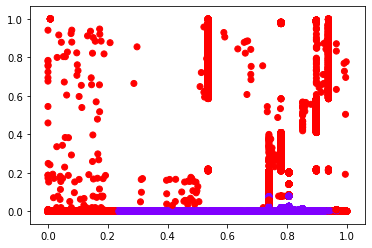

In [23]:
fig, ax = plt.subplots()
ax.scatter(X['Http-Path'],X['Http-Query'], c=X['iforest'], cmap = 'rainbow')
plt.show()

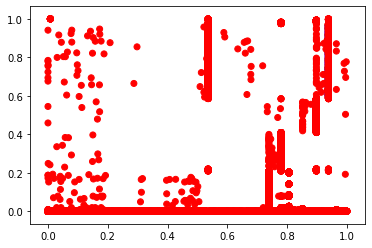

In [24]:
fig, ax = plt.subplots()
ax.scatter(X['Http-Path'],X['Http-Query'], c=X['labels'], cmap = 'rainbow')
plt.show()